# Final Report: BBC Document Analysis

By: Maclean Sherren

<br>


## Introduction

In my research into language models and the various pros and cons to each, I discovered a dataset known as the Google News dataset. Along with this dataset comes prre-trained vectors that contain 300-dimensional vectors for 3 million words and was trained on 100 billion words all related to large media news.

This report aims to explore the effectiveness of Google's pretrained language vectorization model when compared to regular data vectorization. First, I will explore the data, highlighting any anomalies or noteworthy features. Following, the data will be ran through a regular word vectorization model called Word2Vec, a similar model to TP-IDF. The transformed data will then be split and trained on two machine learning models - a linear model and a random forest. The process will then repeat but with the Google News vectorization model instead of the Word2Vec model. Finally, the results of each vectorization model will be compared to help better understand the strengths and weaknesses of each model.

<br>


## Exploratory Data Analysis and Data Engineering

In [32]:
# Libraries
# !! Packages like gensim and sklearn may need to be installed using conda or pip to successfully run this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import gensim
from gensim import corpora, models, similarities, matutils
from gensim import utils
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import gensim.downloader as api
from gensim.models import KeyedVectors

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


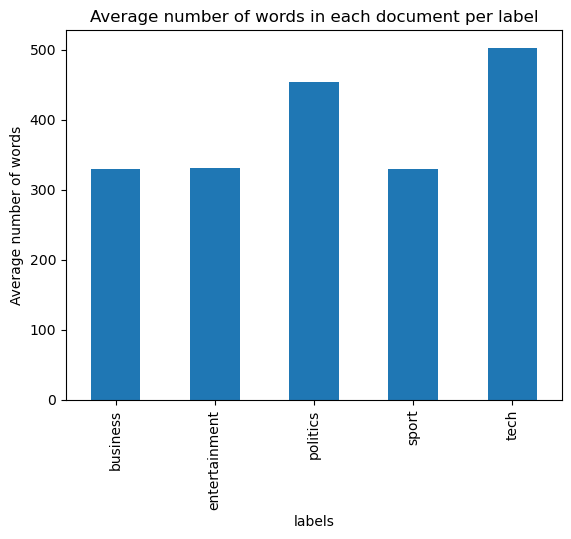

In [33]:
# Data
bbc_data = pd.read_csv('bbc_data.csv')

bbc_data.head()

# Number of documents in each label
print(bbc_data['labels'].value_counts())

# The number of documents in each label plotted

bbc_data_copy = bbc_data.copy()
bbc_data_copy['doc_length'] = bbc_data_copy['data'].apply(lambda x: len(x.split()))

bbc_data_copy.groupby('labels')['doc_length'].mean().plot(kind='bar')
plt.ylabel('Average number of words')
plt.title('Average number of words in each document per label')
plt.show()

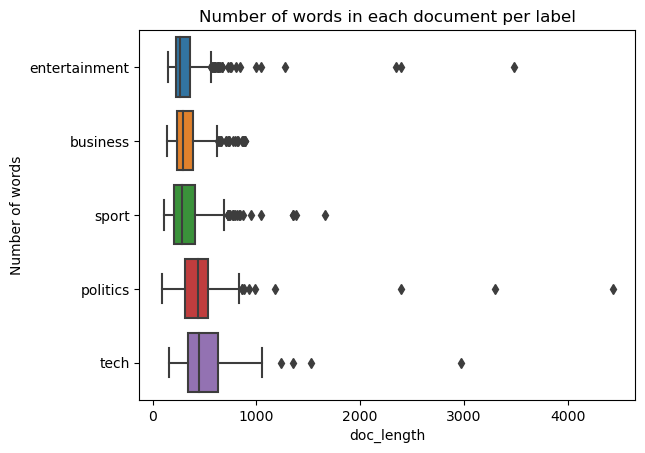

In [34]:
# Boxplot of the number of words in each document per label

sns.boxplot(x='doc_length', y='labels', data=bbc_data_copy)
plt.ylabel('Number of words')
plt.title('Number of words in each document per label')
plt.show()

<br>
Interestingly, the two shortest labels by document word count are sports and entertainment, with business close beind and the topics of politics and tech taking much longer. Each topic has outliers in both length and words used.

Below is the feature engineering. In order for the machine learning models to work well, the text document data must be transformed into vectors and preprocessed. The first vectorization model I will be using is called Word2Vec. Word2Vec is a package that contains a variety of model architectures and optimizations, and works best on word embeddings from large datasets. It is typically used to engineer data for downstream natural language processing tasks, but will instead be used to train two different machine learning models in the next section. The function created below takes in a corpus and a model as the input, splits the data into individual words, creating buckets and averaging the vectors of each work in the buckets before returning the vectors as the result. This is how I will create the X_train and X_test vectorized datasets to be run on the machine learning model.


<br>

In [35]:
# Train test split and preprocess data

X = bbc_data['data'].apply(gensim.utils.simple_preprocess)
y = bbc_data['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
# Feature Engineering: Word2Vec model (similar to TF-IDF, but makes more sense for NLP tasks)

w2v_model = Word2Vec(X_train, vector_size=300, window=15, min_count=2, epochs=10)

# Function created to vectorize each document/data point
def vectorize_data(corpus, model):
    result = []
    for sentence in corpus:
        counter = 0
        bucket = np.zeros(model.vector_size)
        for word in sentence:
            if word in model.wv:
                counter += 1
                bucket += model.wv[word]
            else:
                pass
        bucket = bucket / counter
        result.append(bucket)
    return result

# Vectorize

words = set(w2v_model.wv.index_to_key)
X_train_vec = vectorize_data(X_train, w2v_model)
X_test_vec = vectorize_data(X_test, w2v_model)

# Cell took 20.5 seconds to run

<br>

## Modeling the Word2Vec Vectorized Dataset

The Word2Vec dataset will be trained on two machine learning models - a random forest and linear regression model. For both, cross validation will be done to deteremine model accuracy through a validation score. Then, a PCA graph will be used to visualize the effectiveness of the model on the Vectorized data.

The goal of this project is to compare the two methods of data vectorization, exploring how good the Google model is for News data when compared to Word2Vec (refered to as "W2V" in the comments below). Using more standard machine learning models such as linear regression and a random forest allow us to see the differences between the two types of vectorized data more clearly, as results such as the validation score and PCA plots can be compared directly.

<br>

In [37]:
# Train W2V data on a simple random forest model

rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

# Cell took 3.6 seconds to run

RandomForestClassifier()

In [38]:
# Cross Validation for Random Forest Model
from sklearn.model_selection import cross_val_score

rf_w2v_cv_scores = cross_val_score(rf, X_train_vec, y_train, cv=5)
print('Validation score for each label:', rf_w2v_cv_scores)

rf_w2v_cv_result = pd.DataFrame(
        cross_validate(rf, X_train_vec,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# score
w2v_rf_val_score = rf_w2v_cv_result['val_accuracy'].mean()
w2v_rf_train_score = rf_w2v_cv_result['train_accuracy'].mean() 
w2v_rf_test_score = accuracy_score(y_true=y_test,y_pred=rf.predict(X_test_vec))

print('Averages for all labels combined:')
print('Training Score: ',w2v_rf_train_score)
print('Validation Score: ',w2v_rf_val_score) 
print('Test Score: ',w2v_rf_test_score)

# Cell took 28.0 seconds to run

Validation score for each label: [0.94662921 0.95224719 0.94382022 0.94662921 0.95786517]
Averages for all labels combined:
Training Score:  1.0
Validation Score:  0.9471971971971972
Test Score:  0.9640449438202248


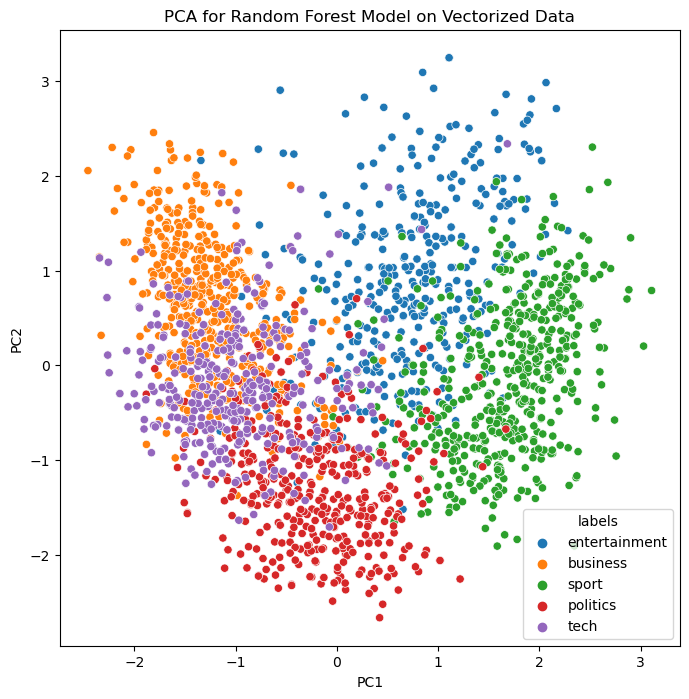

In [39]:
# PCA for Random Forest Model on W2V Data

pca_rf = PCA(n_components=2)
pca_rf_df = pd.DataFrame(pca_rf.fit_transform(vectorize_data(X, w2v_model)), columns=['PC1','PC2'])
pca_rf_df['labels'] = bbc_data['labels'].copy()

plt.figure(figsize=(8,8))
sns.scatterplot(data=pca_rf_df, x='PC1', y='PC2', hue='labels')
plt.title('PCA for Random Forest Model on Vectorized Data')
plt.show()

# Cell took 8.1 seconds to run

In [40]:
# W2V model trained with Logistical Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)

# Cell took 0.9 seconds to run

LogisticRegression(max_iter=1000)

In [41]:
# Cross Validation for Logistic Regression Model

lr_w2v_cv_scores = cross_val_score(lr, X_train_vec, y_train, cv=5)
print('Validation score for each label:', lr_w2v_cv_scores) 

lr_w2v_cv_result = pd.DataFrame(
        cross_validate(lr, X_train_vec,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# score
w2v_lr_val_score = lr_w2v_cv_result['val_accuracy'].mean()
w2v_lr_train_score = lr_w2v_cv_result['train_accuracy'].mean()
w2v_lr_test_score = accuracy_score(y_true=y_test,y_pred=lr.predict(X_test_vec))

print('Averages for all labels combined:')
print('Training Score: ',w2v_lr_train_score)
print('Validation Score: ',w2v_lr_val_score)
print('Test Score: ',w2v_lr_test_score)

# Cell took 10.4 seconds to run

Validation score for each label: [0.9494382  0.95224719 0.94382022 0.94662921 0.96629213]
Averages for all labels combined:
Training Score:  0.9644942774626358
Validation Score:  0.9522533897533898
Test Score:  0.9617977528089887


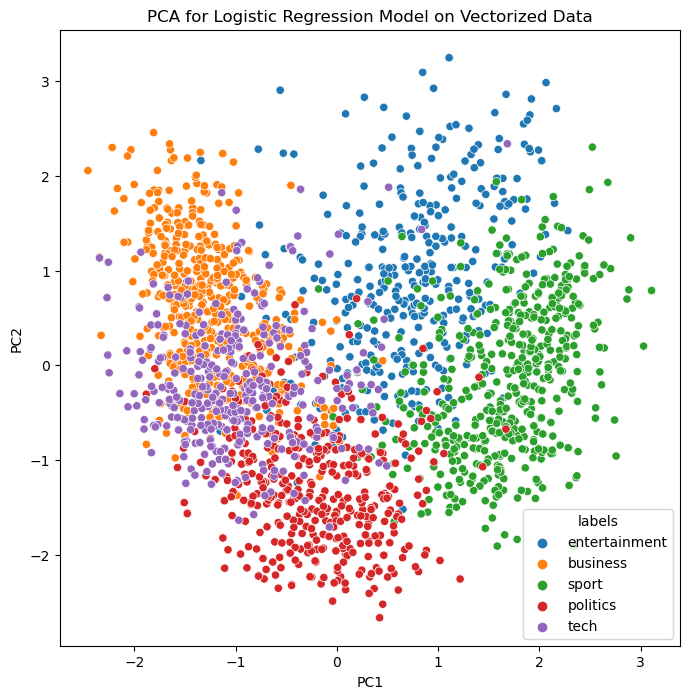

In [42]:
# PCA/Visualize Logistic Regression model on the Vectorized Data

#pca_lr = PCA(n_components=2)
#pca_lr_df = pd.DataFrame(pca_lr.fit_transform(vectorize_data(X, w2v_model)), columns=['PC1','PC2'])
#pca_lr_df['labels'] = bbc_data['labels'].copy()

#plt.figure(figsize=(8,8))
#sns.scatterplot(data=pca_lr_df, x='PC1', y='PC2', hue='labels')
#plt.title('PCA for Logistic Regression Model on Vectorized Data')
#plt.show()

# Cell took 15.7 seconds to run

<br>

## Fitting and Modeling the Google News Vectorized Dataset

The Google News pre-trained model for large text data vectorization is trained on about 100 billion words. The model contains 300-dimensional vectors for 3 million words and phrases. With such acclaim, I felt it must be put to the test. First though, the dataset must be fit to Google's News model. The model itself is 3.6 GB and not contained in this repository. Instead, I have downloaded and added to this repository the single set of vectors, contained in the file "vectors.kv", which work best for this data. The commented code included below is how one would go about downloading this massive model.

<br>

In [43]:
'''
# The line below downloads Google's pre-trained model
wv = api.load('word2vec-google-news-300')

# Save pretrained vector
wv.save('vectors.kv')

# !!! THE COMMENTED PORTION ABOVE TOOK 20 minutes to run/download the pre-trained model
# It is stored in this REPO so no need to download again!
# Line below should load Google's model without downloading anything.
'''

wv = KeyedVectors.load('vectors.kv', mmap='r')

# Function to vectorize data with Google's pre-trained model

def google_data_vectorizer(corpus):
    result = []
    for sentence in corpus:
        counter = 0
        bucket = np.zeros(wv.vector_size)
        for word in sentence:
            if word in wv:
                counter += 1
                bucket += wv[word]
            else:
                pass
        bucket = bucket / counter
        result.append(bucket)
    return result

# Vectorize the data
words = set(wv.index_to_key) # Words in the pre-trained model
X_train_google = google_data_vectorizer(X_train)
X_test_google = google_data_vectorizer(X_test)

# Cell took 18.8 seconds to run

In [44]:
# Random Forest Model with Google's modeled data
rf_google = RandomForestClassifier()
rf_google.fit(X_train_google, y_train)

# Cell took 4.0 seconds to run

RandomForestClassifier()

In [45]:
# Cross validation for RF of google's modeled data

goo_rf_cv_scores = cross_val_score(rf, X_train_vec, y_train, cv=5)
print('Validation score for each label:', goo_rf_cv_scores)

goo_rf_cv_result = pd.DataFrame(
        cross_validate(rf_google, X_train_google,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# score
goo_rf_val_score = goo_rf_cv_result['val_accuracy'].mean()
goo_rf_train_score = goo_rf_cv_result['train_accuracy'].mean() 
goo_rf_test_score = accuracy_score(y_true=y_test,y_pred=rf.predict(X_test_vec))

print('Averages for all labels combined:')
print('Training Score: ',goo_rf_train_score)
print('Validation Score: ',goo_rf_val_score) 
print('Test Score: ',goo_rf_test_score)

# Cell took 34.8 seconds to run

Validation score for each label: [0.95505618 0.94382022 0.94101124 0.94382022 0.96348315]
Averages for all labels combined:
Training Score:  1.0
Validation Score:  0.9494475536142204
Test Score:  0.9640449438202248


Text(0.5, 1.0, 'PCA for Random Forest Model on Google Modeled Data')

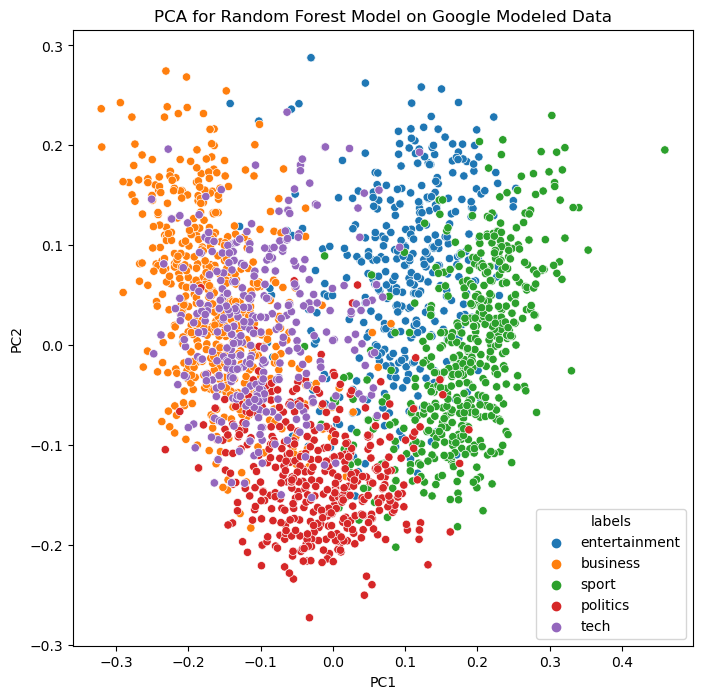

In [46]:
# PCA of Google's modeled data with Random Forest

#pca_rf_google = PCA(n_components=2)
#pca_rf_google_df = pd.DataFrame(pca_rf_google.fit_transform(google_data_vectorizer(X)), columns=['PC1','PC2'])
#pca_rf_google_df['labels'] = bbc_data['labels'].copy()

#plt.figure(figsize=(8,8))
#sns.scatterplot(data=pca_rf_google_df, x='PC1', y='PC2', hue='labels')
#plt.title('PCA for Random Forest Model on Google Modeled Data')

# Cell took 13.0 seconds to run

In [47]:
# Logistical Regression with Google's modeled data

lr_google = LogisticRegression(max_iter=1000)
lr_google.fit(X_train_google, y_train)

# cell took 1.9 seconds to run

LogisticRegression(max_iter=1000)

In [48]:
# Cross validation for LR of google's modeled data

lr_goo_cv_scores = cross_val_score(lr_google, X_train_google, y_train, cv=5)
print('Validation score for each label:', lr_goo_cv_scores)

lr_goo_cv_result = pd.DataFrame(
        cross_validate(lr_google, X_train_google,y_train,scoring=['accuracy'], return_train_score=True, verbose=0, n_jobs=-1, cv=6)
    ).rename(columns={'test_accuracy':'val_accuracy'}).iloc[:,2:]

# score
goo_lr_val_score = lr_goo_cv_result['val_accuracy'].mean()
goo_lr_train_score = lr_goo_cv_result['train_accuracy'].mean()
goo_lr_test_score = accuracy_score(y_true=y_test,y_pred=lr_google.predict(X_test_google))

print('Averages for all labels combined:')
print('Training Score: ',goo_lr_train_score)
print('Validation Score: ',goo_lr_val_score)
print('Test Score: ',goo_lr_test_score)

# Cell took 2.8 seconds to run

Validation score for each label: [0.93258427 0.93820225 0.93820225 0.94101124 0.96629213]
Averages for all labels combined:
Training Score:  0.950449963315903
Validation Score:  0.9410281493614828
Test Score:  0.950561797752809


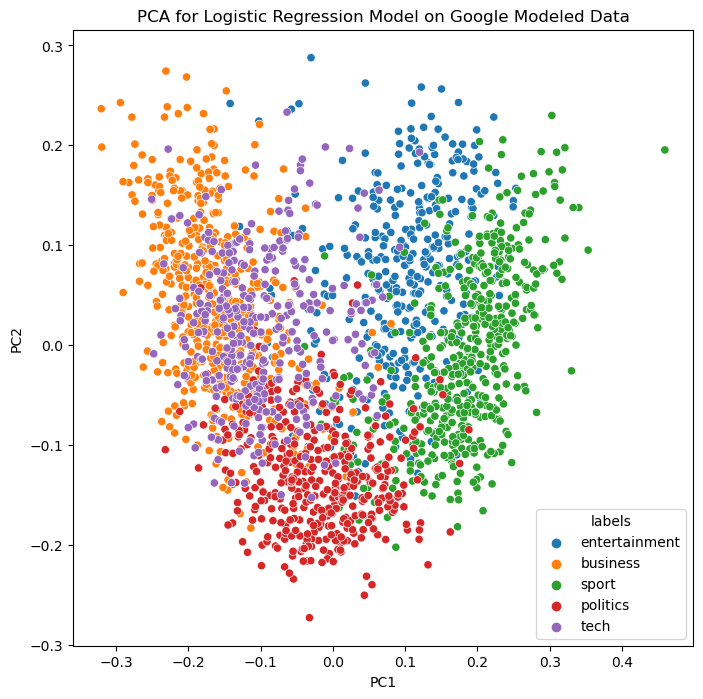

In [49]:
# PCA of Google's modeled data with Logistical Regression

#pca_lr_google = PCA(n_components=2)
#pca_lr_google_df = pd.DataFrame(pca_lr_google.fit_transform(google_data_vectorizer(X)), columns=['PC1','PC2'])
#pca_lr_google_df['labels'] = bbc_data['labels'].copy()

#plt.figure(figsize=(8,8))
#sns.scatterplot(data=pca_lr_google_df, x='PC1', y='PC2', hue='labels')
#plt.title('PCA for Logistic Regression Model on Google Modeled Data')
#plt.show()

# Cell took 16.4 seconds to run

## Discussion: How Did Each Model Do?

Interestinly, we can see that each model had a similar validation score. The validation score varied by a degree of hundreths for all 4 models, demonstrating just how close all these models are in ability. In fact, all 4 models, trained across 2 vectorization methods and 2 machine learning models also had similar levels of accuracy found in their models. Google's accuracy scored higher than the Word2Vec by about 0.1% for both the random forest and linear regression models, but that isn't enough to deem the Google vectoriation model superior to the Word2Vec vectorization model.

Additionally, the PCA charts did not help better determine which model was better, as each model appears to fit the model in a similar way. The code containing the PCA charts were commented out to save space. When PCA charts were performed on test data alone, the spread of data was too far apart to determine which model did so more accurately. Once again, the models appear to be neck and neck.


In [56]:
# Print out all the vectorization scores for all 4 models
print('Google Linear Regression Validation Score: ', round(goo_lr_val_score, 3))
print('Google Random Forest Validation Score: ', round(goo_rf_val_score, 3))
print('Word2Vec Linear Rergression Validation Score: ', round(w2v_lr_val_score, 3))
print('Word2Vec Rrandom Forest Validation Score: ', round(w2v_rf_val_score, 3))

Google Linear Regression Validation Score:  0.941
Google Random Forest Validation Score:  0.949
Word2Vec Linear Rergression Validation Score:  0.952
Word2Vec Rrandom Forest Validation Score:  0.947



## Conclusion and Next Steps

In reading about both the Word2Vec and Google News dataset in preparation for this report, I must admit I am surprised at the results of this report. The Word2Vec vectorization model is not designed or trained on news and media texts, and is instead a more general text model to be used on any dataset containing groupings of words and sentences. The Google vectorization model, however, is specifically trained on News data. It's dimensionality and ability should've made it the more accurate model with the best validation scores for both the linear regression and the random forest. Instead, it appears both word vectorization methods are very good at fitting the data.

In the future, I would recommend testing this with a variety of vectorization methods such as TF-IDF and more standard methods. Additionally, perhaps a different dataset would be more appropriate to test on. This dataset fit both models well, and made it difficult to tell results apart. A larger dataset that's text does all come from a single media outlet would likely be more valuable to test and compare models on. Additionally, it would be interesting to see how these vectorization models compared in accuracy when trained on more complex neural network models, with deeper learning involved.